# 1 - Importing libraries

In [110]:
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import plotly.express as px
import plotly.graph_objects as go
from plotly.graph_objs import Figure
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
from matplotlib.gridspec import GridSpec
import pandas as pd
import numpy as np
import os
import logging
import seaborn as sns


# 2 - Initializing Spark Session

In [2]:
from utils.init_spark_session import SparkSessionManager

SPARK_CONFIG: dict = {
    "spark.driver.extraClassPath": r"C:\mysql-connector-j-8.4.0.jar",
    "spark.executor.extraClassPath": r"C:\mysql-connector-j-8.4.0.jar"
}

spark = SparkSessionManager.get_spark_session(app_name="EDA", config=SPARK_CONFIG)

# 3 - Reading Data

## 3.1 - Setup logging

In [3]:
from loggings.logging_setup import LoggerSetup

logger_config = LoggerSetup()

# importing our analysis logging setup
analysis_logger = logger_config.get_analysis_logger()

## 3.2 - MySQL config

In [4]:
# MySQL config to connect
host = os.getenv('DB_HOST', 'localhost')
user = os.getenv('DB_USER', 'root')
password = os.getenv('DB_PASSWORD', '')
database_name = "revenue_by_state"
table_name = "collection_state"
jdbc_url = f"jdbc:mysql://{host}/{database_name}"

jdbc_properties = {
    "user": user,
    "password": password,
    "driver": "com.mysql.cj.jdbc.Driver"
}

In [5]:
# Reading table from MySQL
try:
    df = spark.read \
        .format("jdbc") \
        .option("url", jdbc_url) \
        .option("dbtable", table_name) \
        .options(**jdbc_properties) \
        .load()
    df.printSchema()
except Exception as e:
    logging.warning(f"An error occurred while loading data from MySQL: {e}")

root
 |-- id: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- state: string (nullable = true)
 |-- region: string (nullable = true)
 |-- import_tax: double (nullable = true)
 |-- export_tax: double (nullable = true)
 |-- ipi_tobacco: double (nullable = true)
 |-- ipi_beverages: double (nullable = true)
 |-- ipi_auto: double (nullable = true)
 |-- ipi_linked_imports: double (nullable = true)
 |-- ipi_others: double (nullable = true)
 |-- income_tax_individual: double (nullable = true)
 |-- income_tax_financial: double (nullable = true)
 |-- income_tax_other: double (nullable = true)
 |-- withholding_tax_employment: double (nullable = true)
 |-- withholding_tax_capital: double (nullable = true)
 |-- withholding_tax_remittances: double (nullable = true)
 |-- withholding_tax_other: double (nullable = true)
 |-- tax_financial_operations: double (nullable = true)
 |-- rural_land_tax: double (nullable = true)
 |-- provisional_tax_transa

In [6]:
df.show()
print(f"columns: {df.columns}")

+---+----+-------+-----+----------+-----------+----------+-----------+-------------+-----------+------------------+-----------+---------------------+--------------------+----------------+--------------------------+-----------------------+---------------------------+---------------------+------------------------+--------------+----------------------------+-------------------------------------+------------+----------------+------------+-------------------------------+-----------------------------------------+-------------------------------------+------------------------------+----------------------------------------+------------------------------------+-------------------------------------------------+----------------------------------+------------------------------------------+-------------------------------------------+------------------------------------------------+-----------------------+---------------------------+------------------------------+---------------+---------------------

In [7]:
# We will use the df a lot of times in our analysis, so it is best practice to cache it
df.cache()

DataFrame[id: int, year: int, month: string, state: string, region: string, import_tax: double, export_tax: double, ipi_tobacco: double, ipi_beverages: double, ipi_auto: double, ipi_linked_imports: double, ipi_others: double, income_tax_individual: double, income_tax_financial: double, income_tax_other: double, withholding_tax_employment: double, withholding_tax_capital: double, withholding_tax_remittances: double, withholding_tax_other: double, tax_financial_operations: double, rural_land_tax: double, provisional_tax_transactions: double, provisional_contribution_transactions: double, cofins: double, cofins_financial: double, cofins_other: double, contribution_social_integration: double, contribution_social_integration_financial: double, contribution_social_integration_other: double, social_contribution_net_profit: double, social_contribution_net_profit_financial: double, social_contribution_net_profit_other: double, intervention_economic_domain_non_deductible_fuels: double, intervent

# 4 - Business Questions

## 4.1 - Revenue Trends: How do the import and export taxes trend over the years across different regions and states?

In [8]:
# selecting columns import and export
tax_columns = [
    "id", "year", "month",
    "state", "region",
    "import_tax", "export_tax"
    ]

tax_trend_df = df.select(*tax_columns)

In [9]:
tax_trend_df.show()

+---+----+-------+-----+----------+-----------+----------+
| id|year|  month|state|    region| import_tax|export_tax|
+---+----+-------+-----+----------+-----------+----------+
|  1|2000|january|   AC|     north|      231.0|       0.0|
|  2|2000|january|   AL|north_east|   475088.0|   33873.0|
|  3|2000|january|   AM|     north|1.1679405E7|       0.0|
|  4|2000|january|   AP|     north|    24267.0|       0.0|
|  5|2000|january|   BA|north_east|1.0476457E7|      13.0|
|  6|2000|january|   CE|north_east|  5576921.0|       0.0|
|  7|2000|january|   DF|   midwest|  2254341.0|      43.0|
|  8|2000|january|   ES|south_east|3.1950799E7|       0.0|
|  9|2000|january|   GO|   midwest|  3747911.0|       0.0|
| 10|2000|january|   MA|north_east|  1714749.0|      69.0|
| 11|2000|january|   MG|south_east|3.5549181E7|      57.0|
| 12|2000|january|   MS|   midwest|   437668.0|       0.0|
| 13|2000|january|   MT|   midwest|   302002.0|       0.0|
| 14|2000|january|   PA|     north|  1321715.0|       0.

In [10]:
def calculate_tax_trends(df: DataFrame, group_columns: list) -> DataFrame:
    """
    Calculate the total import and export taxes trends by grouping data.

    Parameters:
    -----------
    df : pyspark.sql.DataFrame
        The DataFrame containing the tax data, including columns for import taxes,
        export taxes, and the grouping variables (e.g., year, region, state).
        
    group_columns : list
        A list of column names by which to group the data (e.g., ["region", "year"] or ["state", "year"]).
        
    Returns:
    --------
    pyspark.sql.DataFrame
        A DataFrame with the aggregated import and export taxes, ordered by the specified grouping columns.
        The returned DataFrame includes the following columns:
        - group_columns: The columns used for grouping (e.g., "region", "year").
        - import_tax_total: The sum of import taxes for each group.
        - export_tax_total: The sum of export taxes for each group.
    """
    return df.groupBy(*group_columns) \
        .agg(
            F.sum("import_tax").alias("import_tax_total"),
            F.sum("export_tax").alias("export_tax_total")
        ) \
        .orderBy(*group_columns)

In [11]:
def create_tax_trend_plot(df: pd.DataFrame, tax_type: str, column: str) -> Figure:
    """
    Create an interactive line plot for tax trends using Plotly Express.

    This function generates a line plot showing the tax total trends over time,
    grouped by a specified column (e.g., region or state). It supports both
    import and export tax visualizations.

    Parameters:
    -----------
    df : pd.DataFrame
        The DataFrame containing the tax data. It should include columns for year,
        the grouping variable (e.g., region or state), and tax totals 
        (e.g., import_tax_total, export_tax_total).

    tax_type : str
        The type of tax to visualize. Should be either 'import' or 'export'.
        This determines which tax total column is used for the y-axis.

    column : str
        The name of the column to use for grouping and coloring the lines in the plot
        (e.g., 'region' or 'state').

    Returns:
    --------
    plotly.graph_objs._figure.Figure
        A Plotly Figure object containing the interactive line plot.
        The plot includes:
        - Lines representing different groups (e.g., regions or states)
        - A range slider for easy navigation across years
        - Hover information showing the group, year, and tax total
        - Customized layout with appropriate titles and labels

    Note:
    -----
    The function assumes that the tax total columns in the DataFrame
    are named '{tax_type}_tax_total' (e.g., 'import_tax_total', 'export_tax_total').
    """
    col_capit: str = column.capitalize()
    tax_type_capit: str = tax_type.capitalize()
    fig: Figure = px.line(df, x='year', y=f'{tax_type}_tax_total', color=column,
                  title=f'{tax_type_capit} Tax Total by {col_capit} Over Time',
                  labels={f'{tax_type}_tax_total': f'{tax_type_capit} Tax Total', 'year': 'Year'},
                  hover_data=[column, 'year', f'{tax_type}_tax_total'])

    # Customize the layout
    fig.update_layout(
        xaxis_title='Year',
        yaxis_title=f'{tax_type_capit} Tax Total',
        legend_title=col_capit,
        hovermode='closest'
    )

    fig.update_xaxes(rangeslider_visible=True)

    return fig

### 4.1.1 - Regions

In [12]:
region_trend_df: DataFrame = calculate_tax_trends(df=tax_trend_df, group_columns=["region", "year"])

In [13]:
region_trend_df.show()

+-------+----+----------------+----------------+
| region|year|import_tax_total|export_tax_total|
+-------+----+----------------+----------------+
|midwest|2000|    1.26897245E8|         64092.0|
|midwest|2001|    1.68932786E8|       6535773.0|
|midwest|2002|             0.0|           401.0|
|midwest|2003|    2.06559645E8|       9642904.0|
|midwest|2004|     3.9321424E7|        449487.0|
|midwest|2005|     5.3943133E7|       7506901.0|
|midwest|2006|    1.13825951E8|       1551606.0|
|midwest|2007|    2.56440986E8|        158401.0|
|midwest|2008|       1101055.0|          1924.0|
|midwest|2009|       1744754.0|             0.0|
|midwest|2010|             0.0|             0.0|
|midwest|2011|     9.6520692E7|          8081.0|
|midwest|2012|             0.0|             0.0|
|midwest|2013|    2.21152351E8|       1244175.0|
|midwest|2014|    7.22570381E8|       3537614.0|
|midwest|2015|    2.04390493E8|        799168.0|
|midwest|2016|             0.0|           -23.0|
|midwest|2017|      

In [14]:
plt_region_trend_df: pd.DataFrame = region_trend_df.toPandas()

In [15]:
print(plt_region_trend_df)

         region  year  import_tax_total  export_tax_total
0       midwest  2000      1.268972e+08      6.409200e+04
1       midwest  2001      1.689328e+08      6.535773e+06
2       midwest  2002      0.000000e+00      4.010000e+02
3       midwest  2003      2.065596e+08      9.642904e+06
4       midwest  2004      3.932142e+07      4.494870e+05
..          ...   ...               ...               ...
120  south_east  2020      2.294282e+10      0.000000e+00
121  south_east  2021      2.908432e+10     -6.980000e+02
122  south_east  2022      2.859510e+10      0.000000e+00
123  south_east  2023      2.160400e+10      1.908811e+09
124  south_east  2024      1.300649e+10      0.000000e+00

[125 rows x 4 columns]


In [16]:
region_import_tax_fig: Figure = create_tax_trend_plot(df=plt_region_trend_df, tax_type="import", column="region")
region_import_tax_fig.show()

In [17]:
region_export_tax_fig: Figure = create_tax_trend_plot(df=plt_region_trend_df, tax_type="export", column="region")
region_export_tax_fig.show()

### 4.1.2 - States

In [18]:
state_trend_df: DataFrame = calculate_tax_trends(df=tax_trend_df, group_columns=["state", "year"])

In [19]:
state_trend_df.show()

+-----+----+----------------+----------------+
|state|year|import_tax_total|export_tax_total|
+-----+----+----------------+----------------+
|   AC|2000|          9763.0|            13.0|
|   AC|2001|         21124.0|        914962.0|
|   AC|2002|          2515.0|             0.0|
|   AC|2003|         65818.0|            92.0|
|   AC|2004|         70647.0|            10.0|
|   AC|2005|         90912.0|           272.0|
|   AC|2006|        109128.0|           316.0|
|   AC|2007|         94177.0|          3815.0|
|   AC|2008|             0.0|             0.0|
|   AC|2009|             0.0|            12.0|
|   AC|2010|          9990.0|             0.0|
|   AC|2011|         34313.0|           582.0|
|   AC|2012|             0.0|             0.0|
|   AC|2013|         17808.0|          -211.0|
|   AC|2014|        238901.0|             0.0|
|   AC|2015|         13314.0|             0.0|
|   AC|2016|             0.0|             0.0|
|   AC|2017|             0.0|            10.0|
|   AC|2018| 

In [20]:
plt_state_trend: pd.DataFrame = state_trend_df.toPandas()

In [21]:
state_export_tax_fig: Figure = create_tax_trend_plot(df=plt_state_trend, tax_type="export", column="state")
state_export_tax_fig.show()

In [22]:
state_import_tax_fig = create_tax_trend_plot(df=plt_state_trend, tax_type="import", column="state")
state_import_tax_fig.show()

## 4.2 - Tax Contribution Analysis: What is the proportion of income tax (individual, financial, other) to the total tax revenue for each state?

In [23]:
tax_cont_cols: list[str] = ["state", "income_tax_individual", "income_tax_financial", "income_tax_other"]

In [24]:
# Get the percentage of income of each type x total income
tax_cont_df: DataFrame = df.select(*tax_cont_cols)

In [25]:
tax_cont_df.show(n=10, truncate = False)

+-----+---------------------+--------------------+----------------+
|state|income_tax_individual|income_tax_financial|income_tax_other|
+-----+---------------------+--------------------+----------------+
|AC   |177197.0             |643.0               |676835.0        |
|AL   |460804.0             |561.0               |2672106.0       |
|AM   |700623.0             |90828.0             |1.0058713E7     |
|AP   |139226.0             |44135.0             |586572.0        |
|BA   |2498647.0            |177378.0            |2.5695696E7     |
|CE   |1971500.0            |59874.0             |1.3247447E7     |
|DF   |3067374.0            |3913461.0           |7.158268E7      |
|ES   |1620843.0            |2542.0              |2.9105465E7     |
|GO   |1401385.0            |45754.0             |1.8823998E7     |
|MA   |479170.0             |4832.0              |3251185.0       |
+-----+---------------------+--------------------+----------------+
only showing top 10 rows



In [26]:
tax_cont_df: DataFrame = tax_cont_df \
        .groupBy("state") \
        .agg(
            F.sum("income_tax_individual").alias("total_income_tax_individual"),
            F.sum("income_tax_financial").alias("total_income_tax_financial"),
            F.sum("income_tax_other").alias("total_income_tax_other"),
        )

In [27]:
tax_cont_df.show(truncate = False)

+-----+---------------------------+--------------------------+----------------------+
|state|total_income_tax_individual|total_income_tax_financial|total_income_tax_other|
+-----+---------------------------+--------------------------+----------------------+
|SC   |4.417989165E9              |1.36613248E8              |4.1043373858E10       |
|RO   |3.93559838E8               |1686627.0                 |9.34131438E8          |
|PI   |4.77913414E8               |3186856.0                 |1.133410095E9         |
|AM   |8.33524147E8               |2.7208228E7               |9.155131733E9         |
|RR   |1.20215046E8               |668160.0                  |2.14271522E8          |
|GO   |2.323857245E9              |4.230832E7                |1.0399633262E10       |
|TO   |2.22804911E8               |690158.0                  |7.54447571E8          |
|MT   |9.26179102E8               |2.2829869E7               |5.436979123E9         |
|SP   |1.82668910837E11           |1.54454829228E11   

In [28]:
total_income_df: DataFrame = tax_cont_df.withColumn(
    "total_income",
    F.col("total_income_tax_individual") + F.col("total_income_tax_financial") + F.col("total_income_tax_other")
    )

In [29]:
total_income_df.show()

+-----+---------------------------+--------------------------+----------------------+-----------------+
|state|total_income_tax_individual|total_income_tax_financial|total_income_tax_other|     total_income|
+-----+---------------------------+--------------------------+----------------------+-----------------+
|   SC|              4.417989165E9|              1.36613248E8|       4.1043373858E10|  4.5597976271E10|
|   RO|               3.93559838E8|                 1686627.0|          9.34131438E8|    1.329377903E9|
|   PI|               4.77913414E8|                 3186856.0|         1.133410095E9|    1.614510365E9|
|   AM|               8.33524147E8|               2.7208228E7|         9.155131733E9|  1.0015864108E10|
|   RR|               1.20215046E8|                  668160.0|          2.14271522E8|     3.35154728E8|
|   GO|              2.323857245E9|                4.230832E7|       1.0399633262E10|  1.2765798827E10|
|   TO|               2.22804911E8|                  690158.0|  

In [30]:
proportion_income_df: DataFrame = total_income_df \
    .withColumn(
        "individual_income_proportion",
        F.round(F.col("total_income_tax_individual") / F.col("total_income") * 100, scale=2)
    ) \
    .withColumn(
        "financial_income_proportion",
        F.round(F.col("total_income_tax_financial") / F.col("total_income") * 100, scale=2)
    ) \
    .withColumn(
        "other_income_proportion",
        F.round(F.col("total_income_tax_other") / F.col("total_income") * 100, scale=2)
    )

In [31]:
proportion_income_df.show(100)

+-----+---------------------------+--------------------------+----------------------+-----------------+----------------------------+---------------------------+-----------------------+
|state|total_income_tax_individual|total_income_tax_financial|total_income_tax_other|     total_income|individual_income_proportion|financial_income_proportion|other_income_proportion|
+-----+---------------------------+--------------------------+----------------------+-----------------+----------------------------+---------------------------+-----------------------+
|   SC|              4.417989165E9|              1.36613248E8|       4.1043373858E10|  4.5597976271E10|                        9.69|                        0.3|                  90.01|
|   RO|               3.93559838E8|                 1686627.0|          9.34131438E8|    1.329377903E9|                        29.6|                       0.13|                  70.27|
|   PI|               4.77913414E8|                 3186856.0|         1.13

In [32]:
proportion_plt: pd.DataFrame = proportion_income_df.toPandas()

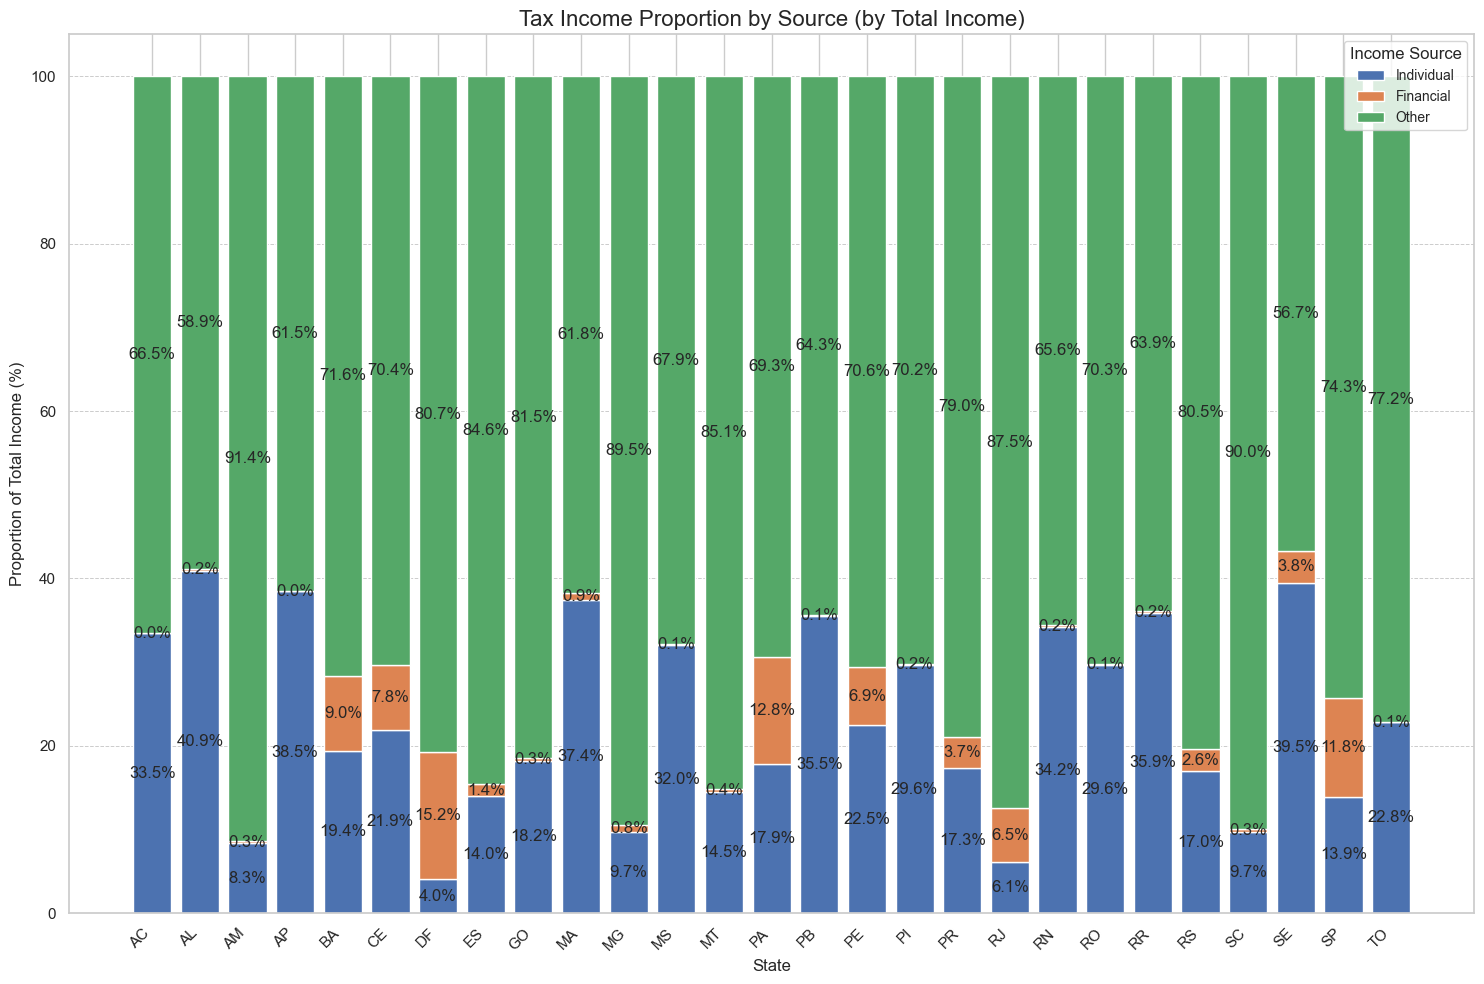

In [33]:
df_sorted = proportion_plt.sort_values('state', ascending=True)

# Create the stacked bar chart
plt.figure(figsize=(15, 10))
sns.set_theme(style="whitegrid")

# Create the stacked bars
plt.bar(df_sorted['state'], df_sorted['individual_income_proportion'], label='Individual')
plt.bar(df_sorted['state'], df_sorted['financial_income_proportion'], 
        bottom=df_sorted['individual_income_proportion'], label='Financial')
plt.bar(df_sorted['state'], df_sorted['other_income_proportion'],
        bottom=df_sorted['individual_income_proportion'] + df_sorted['financial_income_proportion'],
        label='Other')

# Customize the chart
plt.title('Tax Income Proportion by Source (by Total Income)', fontsize=16)
plt.xlabel('State', fontsize=12)
plt.ylabel('Proportion of Total Income (%)', fontsize=12)
plt.legend(title='Income Source', title_fontsize='12', fontsize='10')
plt.xticks(rotation=45, ha='right')

plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)

# Add percentage labels on the bars
for i, state in enumerate(df_sorted['state']):
    individual = df_sorted['individual_income_proportion'].iloc[i]
    financial = df_sorted['financial_income_proportion'].iloc[i]
    other = df_sorted['other_income_proportion'].iloc[i]
    
    plt.text(i, individual/2, f'{individual:.1f}%', ha='center', va='center')
    plt.text(i, individual + financial/2, f'{financial:.1f}%', ha='center', va='center')
    plt.text(i, individual + financial + other/2, f'{other:.1f}%', ha='center', va='center')

plt.tight_layout()
plt.show()

## 4.3 - Are there any seasonal patterns in the tax revenues collected across different states and regions?

In [34]:
df.columns

['id',
 'year',
 'month',
 'state',
 'region',
 'import_tax',
 'export_tax',
 'ipi_tobacco',
 'ipi_beverages',
 'ipi_auto',
 'ipi_linked_imports',
 'ipi_others',
 'income_tax_individual',
 'income_tax_financial',
 'income_tax_other',
 'withholding_tax_employment',
 'withholding_tax_capital',
 'withholding_tax_remittances',
 'withholding_tax_other',
 'tax_financial_operations',
 'rural_land_tax',
 'provisional_tax_transactions',
 'provisional_contribution_transactions',
 'cofins',
 'cofins_financial',
 'cofins_other',
 'contribution_social_integration',
 'contribution_social_integration_financial',
 'contribution_social_integration_other',
 'social_contribution_net_profit',
 'social_contribution_net_profit_financial',
 'social_contribution_net_profit_other',
 'intervention_economic_domain_non_deductible_fuels',
 'intervention_economic_domain_fuels',
 'contribution_security_plan_public_servants',
 'contributions_security_plan_public_servants',
 'contributions_special_fund_inspection_acti

In [53]:
# Define tax columns to analyze
tax_columns = [
    'import_tax', 'export_tax', 'income_tax_individual', 
    'withholding_tax_employment', 'tax_financial_operations'
]

# Create month-name column
df_with_month = df.withColumn('month_name', 
    F.date_format(F.to_date(F.concat(F.col('year'), F.lit('-'), F.col('month')), 'yyyy-MM'), 'MMM'))

# Create expressions for aggregations
agg_expressions = []
for tax_col in tax_columns:
    agg_expressions.extend([
        F.avg(F.col(tax_col)).alias(f'avg_{tax_col}'),
        F.stddev(F.col(tax_col)).alias(f'stddev_{tax_col}'),
        F.min(F.col(tax_col)).alias(f'min_{tax_col}'),
        F.max(F.col(tax_col)).alias(f'max_{tax_col}')
    ])

# Perform single aggregation for all tax types
seasonal_analysis = (df_with_month
    .groupBy('region', 'month', 'month_name')
    .agg(*agg_expressions)
    .orderBy('region', 'month'))

# Calculate year-over-year growth for all tax types in one pass
window_spec = Window.partitionBy('region', 'state').orderBy('year', 'month')

# Create expressions for YoY calculations
yoy_expressions = []
for tax_col in tax_columns:
    df_with_month = df_with_month.withColumn(
        f'prev_year_{tax_col}', 
        F.lag(F.col(tax_col), 12).over(window_spec)
    ).withColumn(
        f'yoy_growth_{tax_col}',
        ((F.col(tax_col) - F.col(f'prev_year_{tax_col}')) / F.col(f'prev_year_{tax_col}')) * 100
    )

# Create expressions for YoY aggregations
yoy_agg_expressions = [
    F.avg(F.col(f'yoy_growth_{tax_col}')).alias(f'avg_yoy_growth_{tax_col}')
    for tax_col in tax_columns
]

# Perform single aggregation for all YoY calculations
yoy_analysis = (df_with_month
    .groupBy('region', 'month', 'month_name')
    .agg(*yoy_agg_expressions)
    .orderBy('region', 'month'))

In [54]:
seasonal_analysis.show()

+-------+---------+----------+------------------+--------------------+--------------+--------------+------------------+------------------+--------------+--------------+-------------------------+----------------------------+-------------------------+-------------------------+------------------------------+---------------------------------+------------------------------+------------------------------+----------------------------+-------------------------------+----------------------------+----------------------------+
| region|    month|month_name|    avg_import_tax|   stddev_import_tax|min_import_tax|max_import_tax|    avg_export_tax| stddev_export_tax|min_export_tax|max_export_tax|avg_income_tax_individual|stddev_income_tax_individual|min_income_tax_individual|max_income_tax_individual|avg_withholding_tax_employment|stddev_withholding_tax_employment|min_withholding_tax_employment|max_withholding_tax_employment|avg_tax_financial_operations|stddev_tax_financial_operations|min_tax_financi

In [55]:
yoy_analysis.show()

+-------+---------+----------+-------------------------+-------------------------+------------------------------------+-----------------------------------------+---------------------------------------+
| region|    month|month_name|avg_yoy_growth_import_tax|avg_yoy_growth_export_tax|avg_yoy_growth_income_tax_individual|avg_yoy_growth_withholding_tax_employment|avg_yoy_growth_tax_financial_operations|
+-------+---------+----------+-------------------------+-------------------------+------------------------------------+-----------------------------------------+---------------------------------------+
|midwest|    april|      NULL|       12.522118891026235|       40.303363749441864|                  -26.45191547134367|                      -10.851679204510999|                    -23.406916069987982|
|midwest|   august|      NULL|        34.65652312246973|       1528.7184905399777|                 -25.226048720455726|                        -7.31176410100486|                     -16.060016

In [56]:
seasonal_analysis.createOrReplaceTempView("seasonal_analysis")
yoy_analysis.createOrReplaceTempView("yoy_analysis")

# Create combined view using SQL
summary_view = df.sparkSession.sql("""
    SELECT 
        s.region,
        s.month,
        s.month_name,
        -- Seasonal metrics
        s.avg_import_tax,
        s.stddev_import_tax,
        y.avg_yoy_growth_import_tax,
        s.avg_export_tax,
        s.stddev_export_tax,
        y.avg_yoy_growth_export_tax,
        -- Add other tax columns as needed
        CASE 
            WHEN s.avg_import_tax > s.avg_export_tax THEN 'Import'
            ELSE 'Export'
        END as dominant_tax_type,
        CASE 
            WHEN y.avg_yoy_growth_import_tax > 10 OR y.avg_yoy_growth_export_tax > 10 THEN 'High Growth'
            WHEN y.avg_yoy_growth_import_tax < -10 OR y.avg_yoy_growth_export_tax < -10 THEN 'Declining'
            ELSE 'Stable'
        END as growth_pattern
    FROM seasonal_analysis s
    JOIN yoy_analysis y
    ON s.region = y.region 
    AND s.month = y.month
    ORDER BY s.region, s.month
""")

In [57]:
summary_view.show()

+-------+---------+----------+------------------+--------------------+-------------------------+------------------+------------------+-------------------------+-----------------+--------------+
| region|    month|month_name|    avg_import_tax|   stddev_import_tax|avg_yoy_growth_import_tax|    avg_export_tax| stddev_export_tax|avg_yoy_growth_export_tax|dominant_tax_type|growth_pattern|
+-------+---------+----------+------------------+--------------------+-------------------------+------------------+------------------+-------------------------+-----------------+--------------+
|midwest|    april|      NULL|        1778723.38|   6841416.411234307|       12.522118891026235|          20276.48|  76082.2621010557|       40.303363749441864|           Import|   High Growth|
|midwest|   august|      NULL|     1422028.15625|   4363338.596799354|        34.65652312246973|20381.114583333332| 88499.20291997517|       1528.7184905399777|           Import|   High Growth|
|midwest| december|      NULL|

In [58]:
summary_view_pd = summary_view.toPandas()

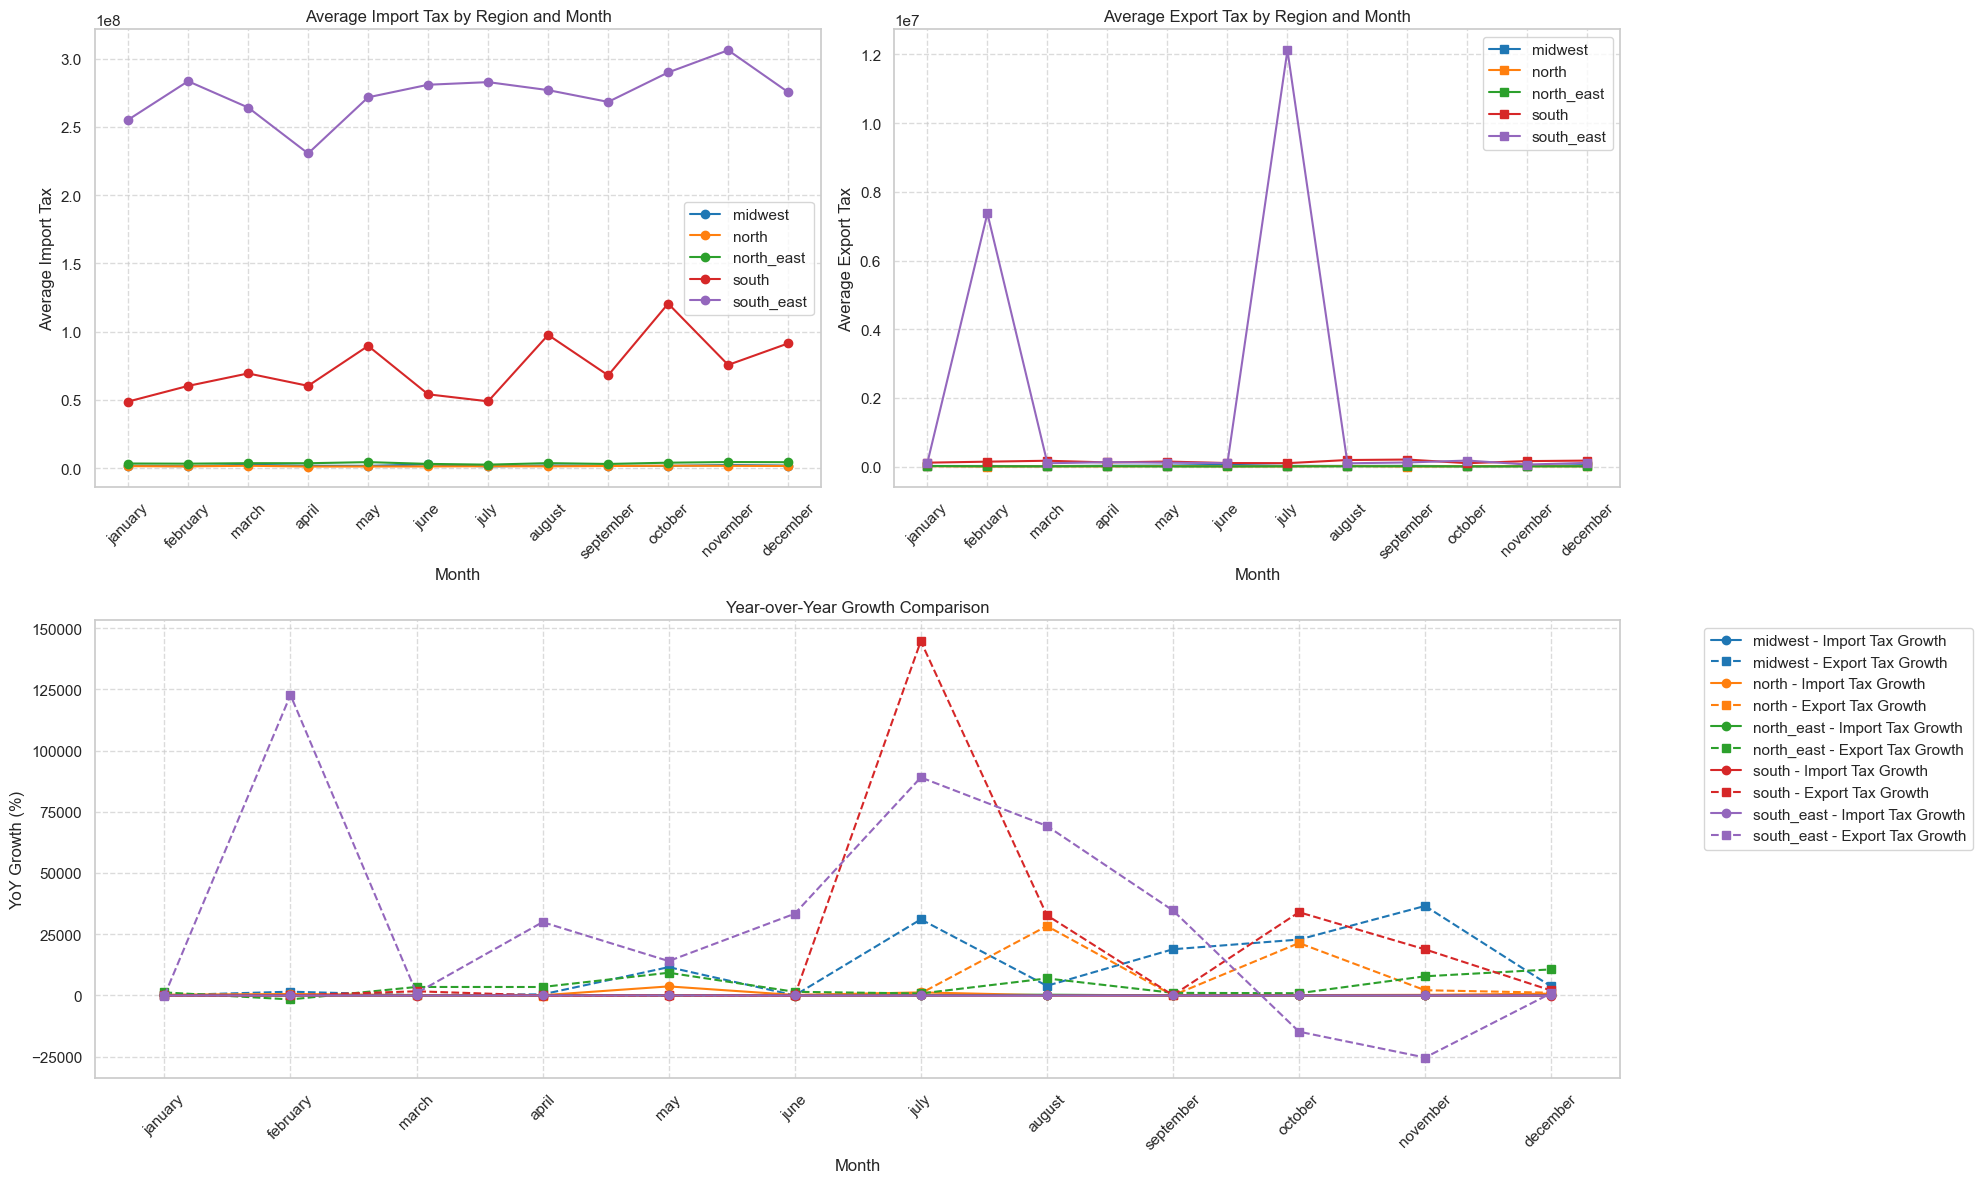

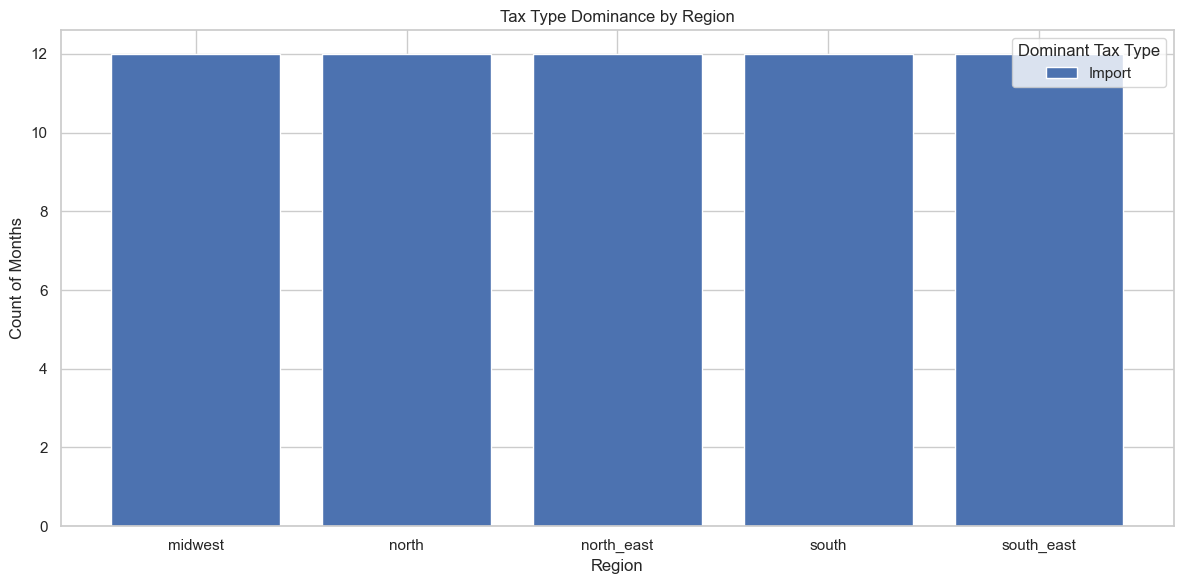

In [64]:
# Convert month to datetime for proper ordering
month_order = ['january', 'february', 'march', 'april', 'may', 'june', 
                'july', 'august', 'september', 'october', 'november', 'december']
summary_view_pd['month'] = pd.Categorical(summary_view_pd['month'], categories=month_order, ordered=True)

# Set up the figure with GridSpec
fig = plt.figure(figsize=(20, 12))
gs = GridSpec(2, 2, figure=fig)

# Define colors for regions
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# 1. Import Tax Seasonal Pattern
ax1 = fig.add_subplot(gs[0, 0])
regions = summary_view_pd['region'].unique()

for idx, region in enumerate(regions):
    region_data = summary_view_pd[summary_view_pd['region'] == region]
    ax1.plot(range(len(month_order)), region_data['avg_import_tax'], 
            marker='o', label=region, color=colors[idx % len(colors)])

ax1.set_xticks(range(len(month_order)))
ax1.set_xticklabels(month_order, rotation=45)
ax1.set_title('Average Import Tax by Region and Month')
ax1.set_xlabel('Month')
ax1.set_ylabel('Average Import Tax')
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend()

# 2. Export Tax Seasonal Pattern
ax2 = fig.add_subplot(gs[0, 1])

for idx, region in enumerate(regions):
    region_data = summary_view_pd[summary_view_pd['region'] == region]
    ax2.plot(range(len(month_order)), region_data['avg_export_tax'], 
            marker='s', label=region, color=colors[idx % len(colors)])

ax2.set_xticks(range(len(month_order)))
ax2.set_xticklabels(month_order, rotation=45)
ax2.set_title('Average Export Tax by Region and Month')
ax2.set_xlabel('Month')
ax2.set_ylabel('Average Export Tax')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.legend()

# 3. Year-over-Year Growth Comparison
ax3 = fig.add_subplot(gs[1, :])

for idx, region in enumerate(regions):
    region_data = summary_view_pd[summary_view_pd['region'] == region]
    
    # Import tax growth
    ax3.plot(range(len(month_order)), region_data['avg_yoy_growth_import_tax'], 
            marker='o', linestyle='-', 
            label=f'{region} - Import Tax Growth',
            color=colors[idx % len(colors)])
    
    # Export tax growth
    ax3.plot(range(len(month_order)), region_data['avg_yoy_growth_export_tax'], 
            marker='s', linestyle='--',
            label=f'{region} - Export Tax Growth',
            color=colors[idx % len(colors)])

ax3.set_xticks(range(len(month_order)))
ax3.set_xticklabels(month_order, rotation=45)
ax3.set_title('Year-over-Year Growth Comparison')
ax3.set_xlabel('Month')
ax3.set_ylabel('YoY Growth (%)')
ax3.grid(True, linestyle='--', alpha=0.7)
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout and display
plt.tight_layout()
plt.show()

# Create an additional visualization for tax type dominance
plt.figure(figsize=(12, 6))
tax_dominance = summary_view_pd.groupby(['region', 'dominant_tax_type']).size().unstack()

# Create stacked bar chart
bottom = np.zeros(len(tax_dominance.index))
for col in tax_dominance.columns:
    plt.bar(tax_dominance.index, tax_dominance[col], bottom=bottom, label=col)
    bottom += tax_dominance[col]

plt.title('Tax Type Dominance by Region')
plt.xlabel('Region')
plt.ylabel('Count of Months')
plt.legend(title='Dominant Tax Type')
plt.tight_layout()
plt.show()

# 4.4 - How have changes in economic policies (e.g., changes in import/export tax rates) impacted tax revenues over the years?

In [70]:
# First, add the total_tax_revenue column to the base dataframe
base_df = df.withColumn(
    "total_tax_revenue", 
    F.col("import_tax") + F.col("export_tax") + 
    F.col("ipi_tobacco") + F.col("ipi_beverages") + 
    F.col("ipi_auto") + F.col("ipi_linked_imports") + 
    F.col("income_tax_individual") + F.col("income_tax_financial")
)

# Yearly analysis
analysis_df = base_df \
    .groupBy("year") \
    .agg(
        F.avg("import_tax").alias("avg_import_tax"),
        F.avg("export_tax").alias("avg_export_tax"),
        F.sum("total_tax_revenue").alias("total_revenue"),
        F.avg("total_tax_revenue").alias("avg_revenue")
    ) \
    .orderBy("year")

# Year-over-year changes
window_spec = Window.orderBy("year")
analysis_df = analysis_df \
    .withColumn(
        "prev_year_import_tax",
        F.lag("avg_import_tax").over(window_spec)
        ) \
    .withColumn(
        "prev_year_export_tax",
        F.lag("avg_export_tax").over(window_spec)
        ) \
    .withColumn(
        "prev_year_revenue",
        F.lag("total_revenue").over(window_spec)
        ) \
    .withColumn(
        "import_tax_change_pct", # Calculate percentage changes
        ((F.col("avg_import_tax") - F.col("prev_year_import_tax")) / F.col("prev_year_import_tax")) * 100
        ) \
    .withColumn(
        "export_tax_change_pct", 
        ((F.col("avg_export_tax") - F.col("prev_year_export_tax")) / F.col("prev_year_export_tax")) * 100
        ) \
    .withColumn(
        "revenue_change_pct", 
        ((F.col("total_revenue") - F.col("prev_year_revenue")) / F.col("prev_year_revenue")) * 100
        )

# Correlation between tax changes and revenue
correlation_df = analysis_df \
    .select(
        F.corr("import_tax_change_pct", "revenue_change_pct").alias("import_tax_revenue_correlation"),
        F.corr("export_tax_change_pct", "revenue_change_pct").alias("export_tax_revenue_correlation")
    )

# Regional analysis using the base_df that already has total_tax_revenue
regional_analysis = base_df \
    .groupBy("year", "region") \
    .agg(
        F.avg("import_tax").alias("avg_import_tax"),
        F.avg("export_tax").alias("avg_export_tax"),
        F.sum("total_tax_revenue").alias("total_revenue")
    ) \
    .orderBy("region", "year")

In [71]:
analysis_df.show()

+----+--------------------+------------------+----------------+--------------------+--------------------+--------------------+-----------------+---------------------+---------------------+-------------------+
|year|      avg_import_tax|    avg_export_tax|   total_revenue|         avg_revenue|prev_year_import_tax|prev_year_export_tax|prev_year_revenue|import_tax_change_pct|export_tax_change_pct| revenue_change_pct|
+----+--------------------+------------------+----------------+--------------------+--------------------+--------------------+-----------------+---------------------+---------------------+-------------------+
|2000|2.6267268271604937E7| 7723.901234567901|  2.550989395E10| 7.873424058641975E7|                NULL|                NULL|             NULL|                 NULL|                 NULL|               NULL|
|2001|   9179657.617283951| 87734.07716049382|    8.69933513E9|2.6849799783950616E7|2.6267268271604937E7|   7723.901234567901|   2.550989395E10|    -65.052865328949

In [72]:
correlation_df.show()

+------------------------------+------------------------------+
|import_tax_revenue_correlation|export_tax_revenue_correlation|
+------------------------------+------------------------------+
|            0.9999999999900092|            0.4499320613943906|
+------------------------------+------------------------------+



In [73]:
regional_analysis.show()

+----+-------+--------------------+-------------------+-------------+
|year| region|      avg_import_tax|     avg_export_tax|total_revenue|
+----+-------+--------------------+-------------------+-------------+
|2000|midwest|  2643692.6041666665|            1335.25| 7.20094878E8|
|2001|midwest|  3519433.0416666665|        136161.9375| 8.88570394E8|
|2002|midwest|                 0.0|  8.354166666666666|       2383.0|
|2003|midwest|        4303325.9375| 200893.83333333334| 1.34944365E9|
|2004|midwest|   819196.3333333334|          9364.3125|1.115965709E9|
|2005|midwest|  1123815.2708333333| 156393.77083333334|1.714567918E9|
|2006|midwest|  2371373.9791666665|          32325.125|3.076722809E9|
|2007|midwest|   5342520.541666667| 3300.0208333333335|3.739009572E9|
|2008|midwest|  22938.645833333332| 40.083333333333336| 5.32112395E8|
|2009|midwest|  36349.041666666664|                0.0| 3.23339815E8|
|2010|midwest|                 0.0|                0.0|1.324803057E9|
|2011|midwest|      

In [74]:
# Convert PySpark DataFrames to Pandas for easier plotting
analysis_pd = analysis_df.toPandas()
correlation_pd = correlation_df.toPandas()
regional_pd = regional_analysis.toPandas()

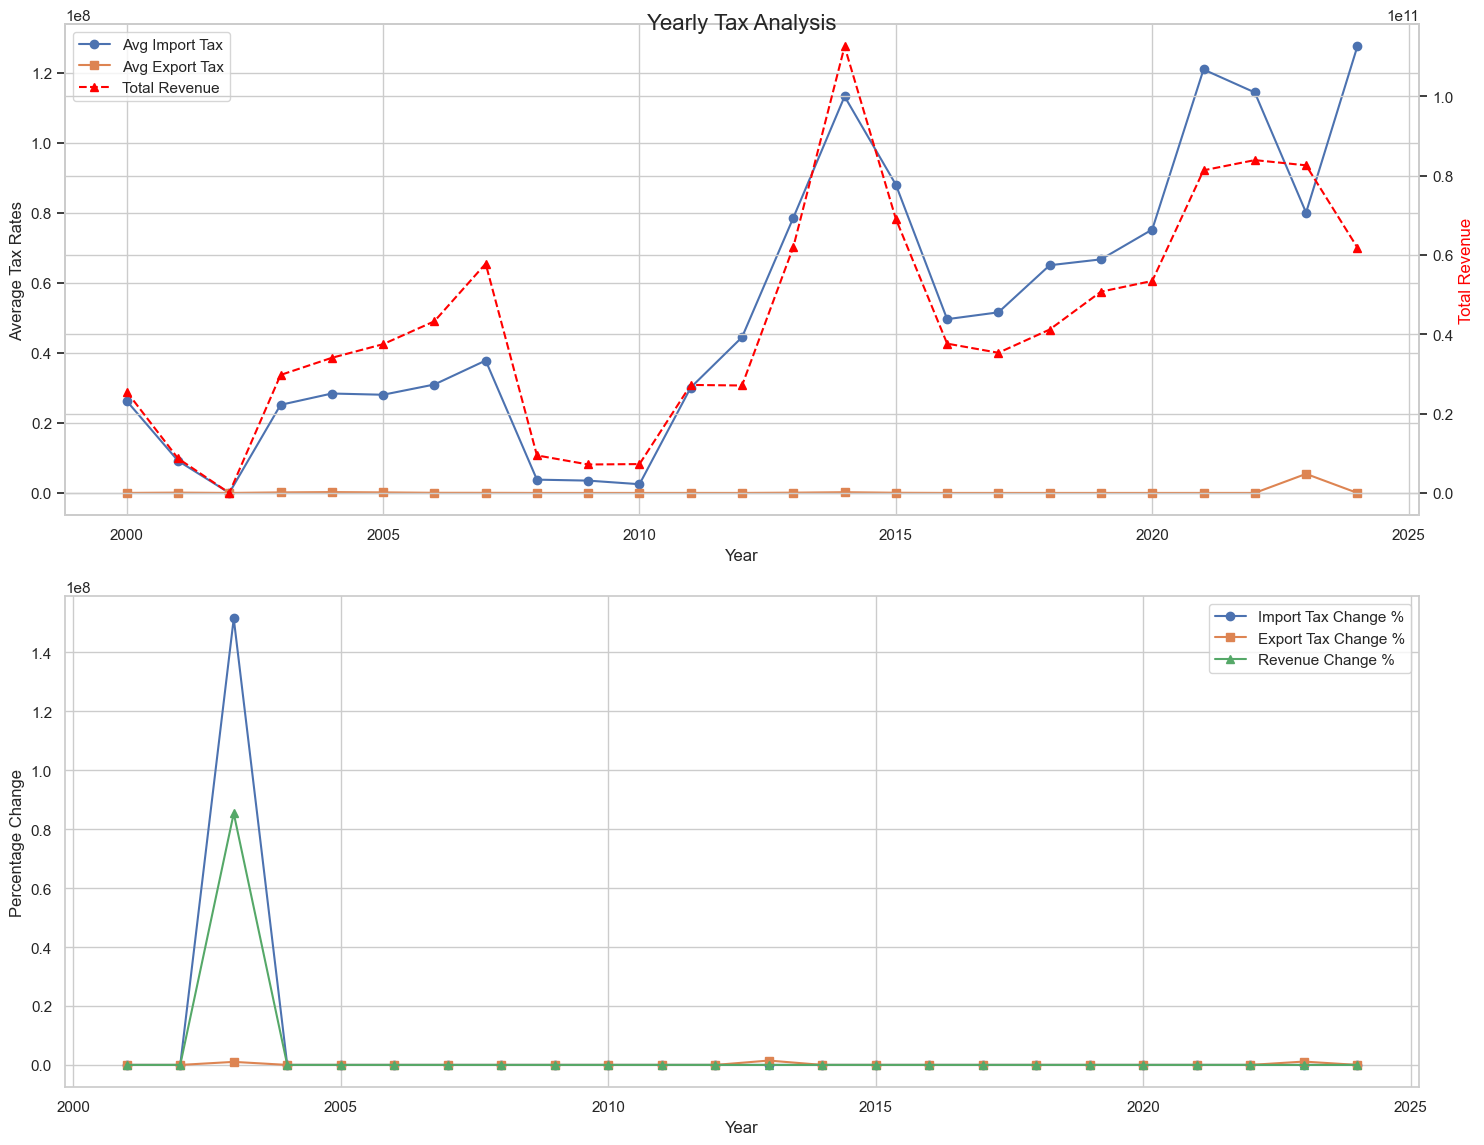

In [77]:
# 1. Visualization for analysis_df
fig, axes = plt.subplots(2, 1, figsize=(15, 12))
fig.suptitle('Yearly Tax Analysis', fontsize=16, y=0.95)

# Plot 1: Tax Rates and Revenue
ax1 = axes[0]
ax1.plot(analysis_pd['year'], analysis_pd['avg_import_tax'], marker='o', label='Avg Import Tax')
ax1.plot(analysis_pd['year'], analysis_pd['avg_export_tax'], marker='s', label='Avg Export Tax')
ax1_twin = ax1.twinx()
ax1_twin.plot(analysis_pd['year'], analysis_pd['total_revenue'], color='red', linestyle='--', 
              marker='^', label='Total Revenue')

ax1.set_xlabel('Year')
ax1.set_ylabel('Average Tax Rates')
ax1_twin.set_ylabel('Total Revenue', color='red')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_twin.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Plot 2: Percentage Changes
ax2 = axes[1]
ax2.plot(analysis_pd['year'], analysis_pd['import_tax_change_pct'], marker='o', label='Import Tax Change %')
ax2.plot(analysis_pd['year'], analysis_pd['export_tax_change_pct'], marker='s', label='Export Tax Change %')
ax2.plot(analysis_pd['year'], analysis_pd['revenue_change_pct'], marker='^', label='Revenue Change %')

ax2.set_xlabel('Year')
ax2.set_ylabel('Percentage Change')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

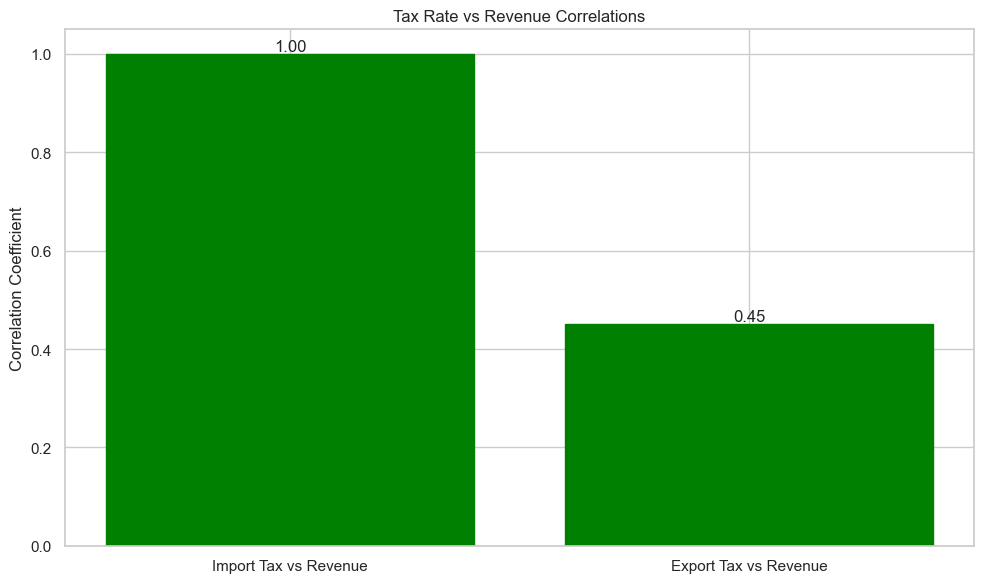

In [78]:
# 2. Visualization for correlation_df
fig, ax = plt.subplots(figsize=(10, 6))

correlations = [
    correlation_pd['import_tax_revenue_correlation'].iloc[0],
    correlation_pd['export_tax_revenue_correlation'].iloc[0]
]

bars = ax.bar(['Import Tax vs Revenue', 'Export Tax vs Revenue'], correlations)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2., height,
            f'{height:.2f}',
            ha='center', va='bottom')

ax.set_title('Tax Rate vs Revenue Correlations')
ax.set_ylabel('Correlation Coefficient')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Add color based on correlation direction
for bar, correlation in zip(bars, correlations):
    bar.set_color('green' if correlation > 0 else 'red')

plt.tight_layout()
plt.show()

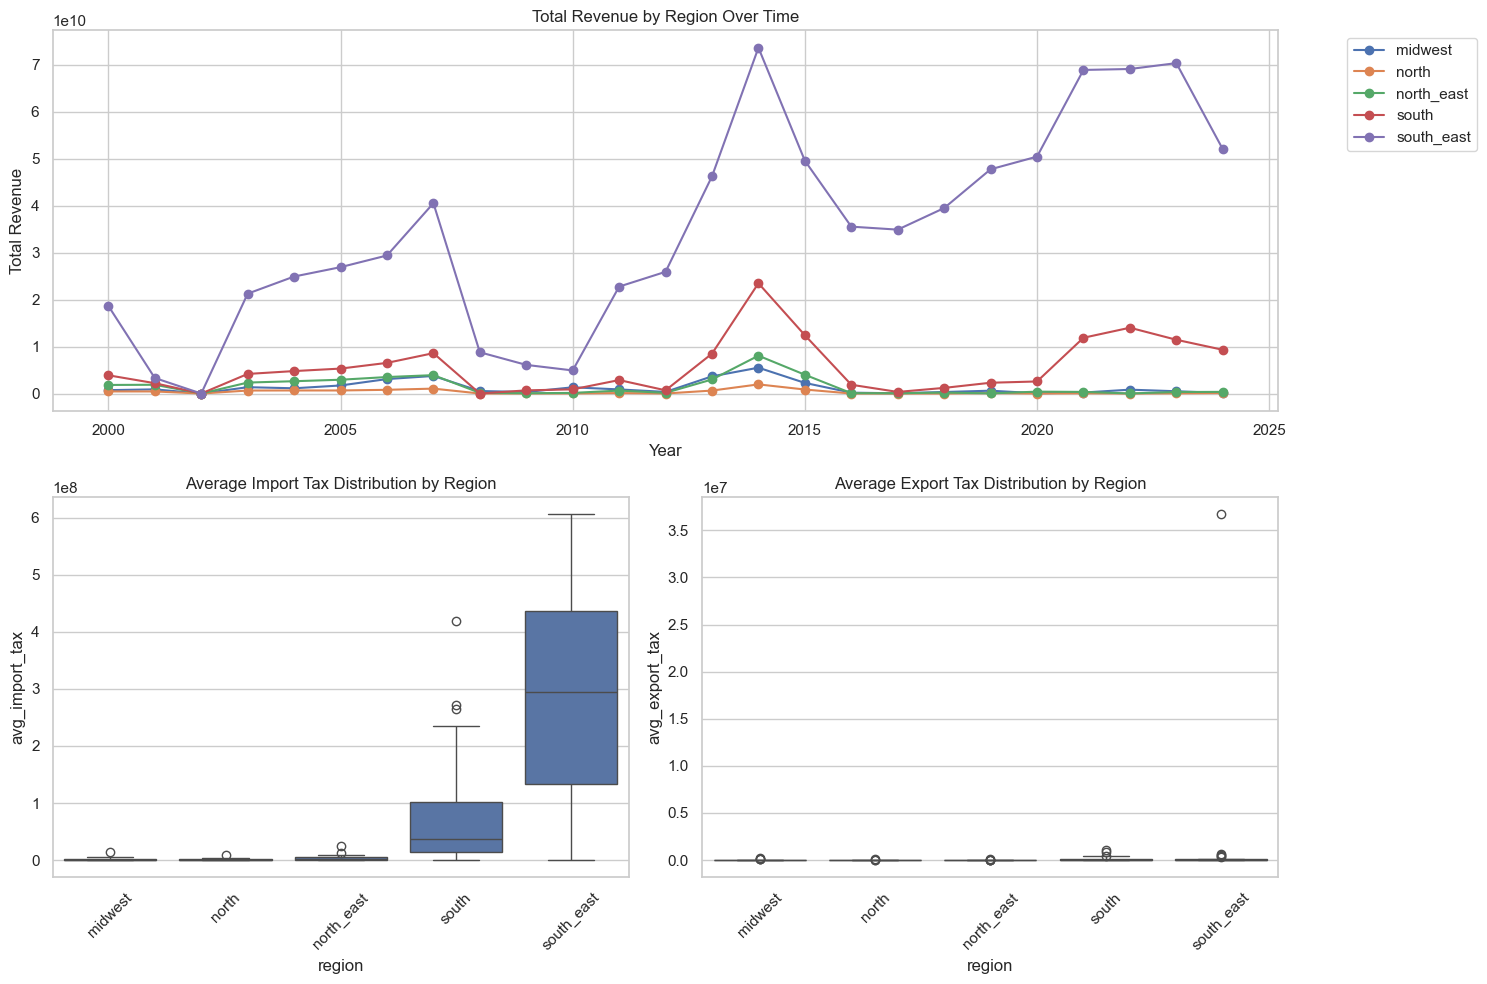

In [79]:
# 3. Visualization for regional_analysis
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(2, 2)

# Plot 1: Regional Revenue Trends
ax1 = fig.add_subplot(gs[0, :])
for region in regional_pd['region'].unique():
    region_data = regional_pd[regional_pd['region'] == region]
    ax1.plot(region_data['year'], region_data['total_revenue'], marker='o', label=region)

ax1.set_title('Total Revenue by Region Over Time')
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Revenue')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 2: Average Import Tax by Region
ax2 = fig.add_subplot(gs[1, 0])
sns.boxplot(data=regional_pd, x='region', y='avg_import_tax', ax=ax2)
ax2.set_title('Average Import Tax Distribution by Region')
ax2.tick_params(axis='x', rotation=45)  # Use tick_params to rotate the labels

# Plot 3: Average Export Tax by Region
ax3 = fig.add_subplot(gs[1, 1])
sns.boxplot(data=regional_pd, x='region', y='avg_export_tax', ax=ax3)
ax3.set_title('Average Export Tax Distribution by Region')
ax3.tick_params(axis='x', rotation=45)  # Use tick_params to rotate the labels

plt.tight_layout()
plt.show()

# 4.5 - What is the contribution of specific sectors (e.g., tobacco, beverages, auto) to the total IPI (Excise Tax on Industrialized Products) revenue?

In [80]:
df.columns

['id',
 'year',
 'month',
 'state',
 'region',
 'import_tax',
 'export_tax',
 'ipi_tobacco',
 'ipi_beverages',
 'ipi_auto',
 'ipi_linked_imports',
 'ipi_others',
 'income_tax_individual',
 'income_tax_financial',
 'income_tax_other',
 'withholding_tax_employment',
 'withholding_tax_capital',
 'withholding_tax_remittances',
 'withholding_tax_other',
 'tax_financial_operations',
 'rural_land_tax',
 'provisional_tax_transactions',
 'provisional_contribution_transactions',
 'cofins',
 'cofins_financial',
 'cofins_other',
 'contribution_social_integration',
 'contribution_social_integration_financial',
 'contribution_social_integration_other',
 'social_contribution_net_profit',
 'social_contribution_net_profit_financial',
 'social_contribution_net_profit_other',
 'intervention_economic_domain_non_deductible_fuels',
 'intervention_economic_domain_fuels',
 'contribution_security_plan_public_servants',
 'contributions_security_plan_public_servants',
 'contributions_special_fund_inspection_acti

In [92]:
ipi_cols = ['state', 'year', 'ipi_tobacco', 'ipi_beverages', 'ipi_auto', 'ipi_linked_imports', 'ipi_others']
ipi_sum_df = df.select(*ipi_cols) \
    .groupBy('state', 'year') \
    .agg(
        F.sum("ipi_tobacco").alias("ipi_tobacco_total"),
        F.sum("ipi_beverages").alias("ipi_beverages_total"),
        F.sum("ipi_auto").alias("ipi_auto_total"),
        F.sum("ipi_linked_imports").alias("ipi_linked_imports_total"),
        F.sum("ipi_others").alias("ipi_others_total")
    )

In [95]:
window_spec = Window.partitionBy('state', 'year')
ipi_total_df = ipi_sum_df \
    .withColumn(
    "ipi_total_revenue",
        (
            F.sum("ipi_tobacco_total").over(window_spec) +
            F.sum("ipi_beverages_total").over(window_spec) +
            F.sum("ipi_auto_total").over(window_spec) +
            F.sum("ipi_linked_imports_total").over(window_spec) +
            F.sum("ipi_others_total").over(window_spec)
        ).alias("ipi_total_revenue")
    )

In [96]:
ipi_total_df.show()

+-----+----+-----------------+-------------------+--------------+------------------------+----------------+-----------------+
|state|year|ipi_tobacco_total|ipi_beverages_total|ipi_auto_total|ipi_linked_imports_total|ipi_others_total|ipi_total_revenue|
+-----+----+-----------------+-------------------+--------------+------------------------+----------------+-----------------+
|   AC|2000|        3356005.0|                0.0|           0.0|                  1310.0|        134567.0|        3491882.0|
|   AC|2001|        3696625.0|              126.0|           0.0|                  7086.0|        291740.0|        3995577.0|
|   AC|2002|              0.0|             1744.0|           0.0|                   570.0|             0.0|           2314.0|
|   AC|2003|        3661251.0|             6071.0|        5946.0|                 40197.0|        141540.0|        3855005.0|
|   AC|2004|        4177527.0|             6487.0|       11411.0|                 17561.0|        112032.0|        432

In [103]:
proportion_ipi_revenue = ipi_total_df \
    .withColumn(
        "ipi_tobacco_percentage",
        F.coalesce(
            F.round(
                F.when(F.col("ipi_total_revenue") != 0, F.col("ipi_tobacco_total") / F.col("ipi_total_revenue") * 100)
                .otherwise(0), 2)
        , F.lit(0))
    ) \
    .withColumn(
        "ipi_beverages_percentage",
        F.coalesce(
            F.round(
                F.when(F.col("ipi_total_revenue") != 0, F.col("ipi_beverages_total") / F.col("ipi_total_revenue") * 100)
                .otherwise(0), 2)
        , F.lit(0))
    ) \
    .withColumn(
        "ipi_auto_percentage",
        F.coalesce(
            F.round(
                F.when(F.col("ipi_total_revenue") != 0, F.col("ipi_auto_total") / F.col("ipi_total_revenue") * 100)
                .otherwise(0), 2)
        , F.lit(0))
    ) \
    .withColumn(
        "ipi_linked_imports_percentage",
        F.coalesce(
            F.round(
                F.when(F.col("ipi_total_revenue") != 0, F.col("ipi_linked_imports_total") / F.col("ipi_total_revenue") * 100)
                .otherwise(0), 2)
        , F.lit(0))
    ) \
    .withColumn(
        "ipi_others_percentage",
        F.coalesce(
            F.round(
                F.when(F.col("ipi_total_revenue") != 0, F.col("ipi_others_total") / F.col("ipi_total_revenue") * 100)
                .otherwise(0), 2)
        , F.lit(0))
    )

In [104]:
proportion_ipi_revenue.show()

+-----+----+-----------------+-------------------+--------------+------------------------+----------------+-----------------+----------------------+------------------------+-------------------+-----------------------------+---------------------+
|state|year|ipi_tobacco_total|ipi_beverages_total|ipi_auto_total|ipi_linked_imports_total|ipi_others_total|ipi_total_revenue|ipi_tobacco_percentage|ipi_beverages_percentage|ipi_auto_percentage|ipi_linked_imports_percentage|ipi_others_percentage|
+-----+----+-----------------+-------------------+--------------+------------------------+----------------+-----------------+----------------------+------------------------+-------------------+-----------------------------+---------------------+
|   AC|2000|        3356005.0|                0.0|           0.0|                  1310.0|        134567.0|        3491882.0|                 96.11|                     0.0|                0.0|                         0.04|                 3.85|
|   AC|2001|    

In [105]:
proportion_ipi_revenue_pd = proportion_ipi_revenue.toPandas()

In [112]:
# Create figure with secondary y-axis
fig = make_subplots(
    rows=5, cols=1,
    subplot_titles=("Tobacco", "Beverages", "Auto", "Linked Imports", "Others"),
    vertical_spacing=0.03,
    row_heights=[0.2, 0.2, 0.2, 0.2, 0.2]
)

sectors = ['tobacco', 'beverages', 'auto', 'linked_imports', 'others']
colors = px.colors.sequential.Viridis

for idx, sector in enumerate(sectors, 1):
    # Pivot the data for each sector
    pivot_data = proportion_ipi_revenue_pd.pivot(
        index='year',
        columns='state',
        values=f'ipi_{sector}_percentage'
    )
    
    # Create heatmap
    fig.add_trace(
        go.Heatmap(
            z=pivot_data.values,
            x=pivot_data.columns,
            y=pivot_data.index,
            colorscale=colors,
            zmin=0,
            zmax=100,
            colorbar=dict(
                title='%',
                len=0.2,
                y=0.1 + (idx-1)*0.2,
                yanchor='bottom'
            ),
            hoverongaps=False,
            hovertemplate='State: %{x}<br>Year: %{y}<br>Percentage: %{z:.1f}%<extra></extra>'
        ),
        row=idx,
        col=1
    )

# Update layout
fig.update_layout(
    height=1200,
    width=1000,
    title={
        'text': 'IPI Revenue Contribution by Sector (2003-2024)',
        'x': 0.5,
        'y': 0.98,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 20}
    },
    showlegend=False,
    paper_bgcolor='white',
    plot_bgcolor='white'
)

# Update axes labels and ticks
for i in range(1, 6):
    fig.update_xaxes(
        title='States' if i == 5 else None,
        tickangle=45,
        row=i,
        col=1,
        gridcolor='lightgrey',
        showgrid=True
    )
    fig.update_yaxes(
        title='Year' if i == 3 else None,
        row=i,
        col=1,
        gridcolor='lightgrey',
        showgrid=True
    )

fig.show()

# 4.6 - How do withholding tax revenues from employment compare across states with varying economically active populations?

In [118]:
# Per capita withholding tax
withholding_tax_per_capita_expr = F.col("withholding_tax_employment") / F.col("economically_active_population")

# Metrics at the state and year level
analysis_df = df.withColumn(
    "withholding_tax_per_capita", withholding_tax_per_capita_expr
).groupBy("state", "year").agg(
    F.avg("withholding_tax_employment").alias("avg_withholding_tax"),
    F.avg("withholding_tax_per_capita").alias("avg_withholding_tax_per_capita"),
    F.avg("economically_active_population").alias("avg_economic_population"),
    F.sum("withholding_tax_employment").alias("total_withholding_tax")
)

# State rankings and percentiles
window_spec = Window.orderBy(F.desc("avg_withholding_tax_per_capita"))

ranked_df = analysis_df.withColumn(
    "rank", F.row_number().over(window_spec)
).withColumn(
    "percentile", F.percent_rank().over(window_spec)
)

# Relative tax burden (mean of avg_withholding_tax_per_capita)
window_partition = Window.partitionBy()
final_df = ranked_df.withColumn(
    "relative_tax_burden", 
    F.col("avg_withholding_tax_per_capita") / F.mean("avg_withholding_tax_per_capita").over(window_partition)
)

# Select and format final columns
withholding_final_df = final_df.orderBy(F.desc("avg_withholding_tax_per_capita")).select(
    "state",
    "year",
    F.round("avg_withholding_tax_per_capita", 2).alias("tax_per_capita"),
    F.round("relative_tax_burden", 2).alias("relative_burden"),
    "rank",
    F.round("avg_economic_population", 0).alias("economic_population")
)

withholding_final_df.show()

+-----+----+--------------+---------------+----+-------------------+
|state|year|tax_per_capita|relative_burden|rank|economic_population|
+-----+----+--------------+---------------+----+-------------------+
|   DF|2021|    1406927.85|          29.48|   1|             2494.0|
|   DF|2020|    1324142.61|          27.74|   2|             2491.0|
|   DF|2019|    1322584.62|          27.71|   3|             2460.0|
|   DF|2018|    1187169.85|          24.87|   4|             2442.0|
|   DF|2017|    1139972.08|          23.88|   5|             2391.0|
|   DF|2016|    1012405.59|          21.21|   6|             2314.0|
|   DF|2015|     904808.74|          18.96|   7|             2286.0|
|   DF|2014|     816299.36|           17.1|   8|             2247.0|
|   DF|2013|     756915.75|          15.86|   9|             2225.0|
|   DF|2012|     722491.48|          15.14|  10|             2161.0|
|   SP|2021|     107369.47|           2.25|  11|            38573.0|
|   RJ|2021|      96256.38|       

In [119]:
# Correlation between economic population and total withholding tax
correlation = final_df.stat.corr("avg_economic_population", "total_withholding_tax")
print(f"\nCorrelation between economic population and total withholding tax: {correlation:.3f}")

# Year-over-year changes
yoy_window = Window.partitionBy("state").orderBy("year", "month")
yoy_changes = df.withColumn(
    "prev_year_tax", F.lag("withholding_tax_employment").over(yoy_window)
).withColumn(
    "yoy_change_pct", 
    F.when(F.col("prev_year_tax").isNotNull(),
           (F.col("withholding_tax_employment") - F.col("prev_year_tax")) / F.col("prev_year_tax") * 100
    ).otherwise(None)
)

# Average year-over-year changes by state
withholding_yoy_result = yoy_changes.groupBy("state").agg(
    F.round(F.avg("yoy_change_pct"), 2).alias("avg_yoy_change_pct")
).orderBy(F.desc("avg_yoy_change_pct"))

withholding_yoy_result.show()


Correlation between economic population and total withholding tax: 0.418
+-----+------------------+
|state|avg_yoy_change_pct|
+-----+------------------+
|   AP|             20.88|
|   PI|             11.18|
|   SP|              5.26|
|   DF|              4.73|
|   RO|              4.05|
|   MT|               1.8|
|   AL|              0.88|
|   AC|              0.41|
|   PB|             -0.07|
|   TO|             -0.78|
|   MS|             -1.52|
|   RN|             -1.91|
|   AM|             -2.79|
|   MA|             -2.89|
|   RJ|             -3.19|
|   SE|             -4.88|
|   PA|              -7.0|
|   CE|             -8.99|
|   GO|             -9.41|
|   BA|             -10.6|
+-----+------------------+
only showing top 20 rows

